In [29]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import (
    Conv2D, Activation, BatchNormalization,
    UpSampling2D, Input, Concatenate
)
from tensorflow.keras.layers import Dropout, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

In [30]:
tf.keras.backend.clear_session()

In [31]:
np.random.seed(42)
tf.random.set_seed(42)

# Hyperparameters

In [32]:
IMAGE_SIZE = 256
EPOCHS = 30
BATCH_SIZE = 2
LR = 1e-4

PATH = "."

# Dataset

In [33]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))
    
    total_size = len(images)
    valid_size = int(total_size * split)
    test_size = int(total_size * split)
    
    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)
    
    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)
    
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [34]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x / 255.0
    
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x / 255.0
    x = np.expand_dims(x, axis=-1)
    
    return x

## Building the tf.data pipeline

In [35]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        
        return x, y
    
    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    
    return x, y


def tf_dataset(x, y, batch=BATCH_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    
    return dataset

In [36]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

Training data:  624
Validation data:  78
Testing data:  78


In [37]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    
    return x

# Model

In [38]:
#inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
#encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)

In [39]:
#encoder.summary()

In [40]:
#inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
#encoder2 = DenseNet201(input_tensor=inputs, weights='imagenet', include_top=False)

In [41]:
#encoder2.summary()

In [42]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")

    encoder = DenseNet201(input_tensor=inputs, weights="imagenet", include_top=False)
    # skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    skip_connection_names = ["input_image", "conv1/relu", "pool2_relu", "pool3_relu", "pool4_relu"]
    encoder_output = encoder.get_layer("relu").output
    #skip_connection_names = ["input_image", "re_lu", "re_lu_3", "re_lu_7"]
    #encoder_output = encoder.get_layer("re_lu_16").output

    f = [16, 32, 48, 64, 80]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])

        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs, x)
    return model

In [43]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['input_image[0][0]']         
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1/conv[0][0]']      

# Metrics

In [44]:
smooth = 1e-15

def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# Training

In [45]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH_SIZE)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH_SIZE)

In [46]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [47]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [48]:
train_steps = len(train_x) // BATCH_SIZE
valid_steps = len(valid_x) // BATCH_SIZE

if len(train_x) % BATCH_SIZE != 0:
    train_steps += 1
if len(valid_x) % BATCH_SIZE != 0:
    valid_steps += 1
    
model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/30


2024-01-16 17:22:19.702371: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-16 17:22:19.842251: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-16 17:22:19.856329: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-16 17:22:43.501599: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 446.34MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-01-16 17:22:43.680617: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 446.34MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performa

312/312 [==============================] - 1150s 2s/step - loss: 0.7263 - dice_coef: 0.2737 - recall: 0.8403 - precision: 0.3003 - val_loss: 0.7103 - val_dice_coef: 0.2897 - val_recall: 0.8314 - val_precision: 0.4556 - lr: 1.0000e-04
Epoch 2/30
312/312 [==============================] - 751s 2s/step - loss: 0.6520 - dice_coef: 0.3480 - recall: 0.8771 - precision: 0.5018 - val_loss: 0.6865 - val_dice_coef: 0.3135 - val_recall: 0.7364 - val_precision: 0.6317 - lr: 1.0000e-04
Epoch 3/30
312/312 [==============================] - 550s 2s/step - loss: 0.5983 - dice_coef: 0.4017 - recall: 0.8957 - precision: 0.6321 - val_loss: 0.6571 - val_dice_coef: 0.3429 - val_recall: 0.6362 - val_precision: 0.7095 - lr: 1.0000e-04
Epoch 4/30
312/312 [==============================] - 501s 2s/step - loss: 0.5535 - dice_coef: 0.4465 - recall: 0.8929 - precision: 0.6802 - val_loss: 0.6264 - val_dice_coef: 0.3736 - val_recall: 0.6195 - val_precision: 0.7431 - lr: 1.0000e-04
Epoch 5/30
312/312 [==============

In [49]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH_SIZE)

test_steps = len(test_x) // BATCH_SIZE
if len(test_x) % BATCH_SIZE != 0:
    test_steps += 1
    
model.evaluate(test_dataset, steps=test_steps)

39/39 [==============================] - 13s 344ms/step - loss: 0.3249 - dice_coef: 0.6751 - recall: 0.5924 - precision: 0.7490


[0.32491788268089294,
 0.6750821471214294,
 0.5924365520477295,
 0.748975932598114]

# Results

In [50]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

In [51]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

1/1 [==============================] - 0s 37ms/step


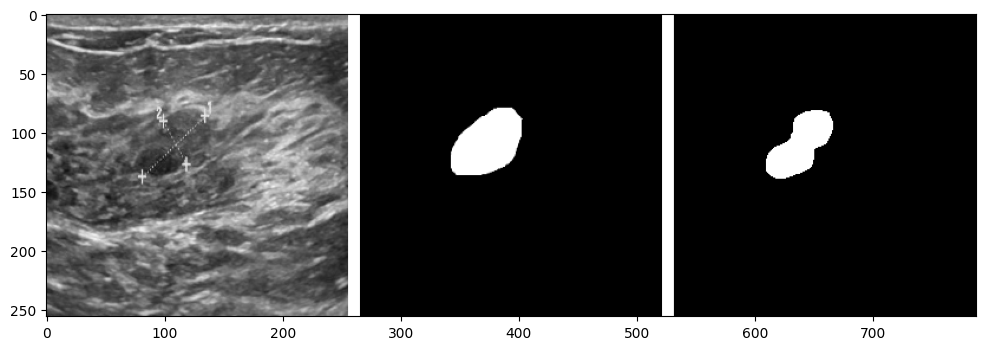

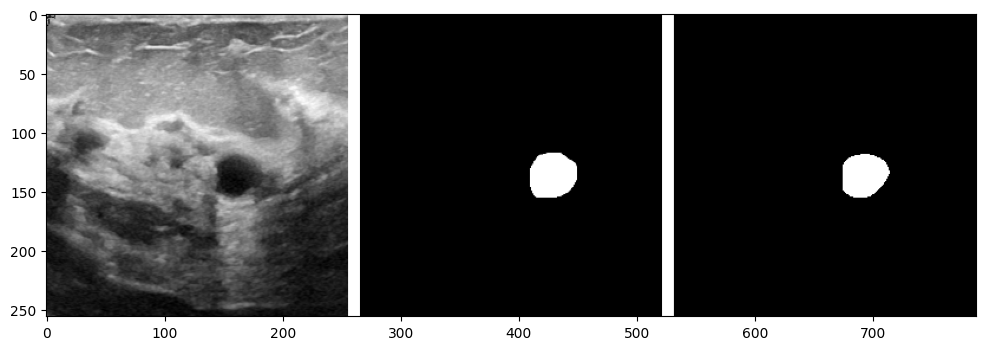

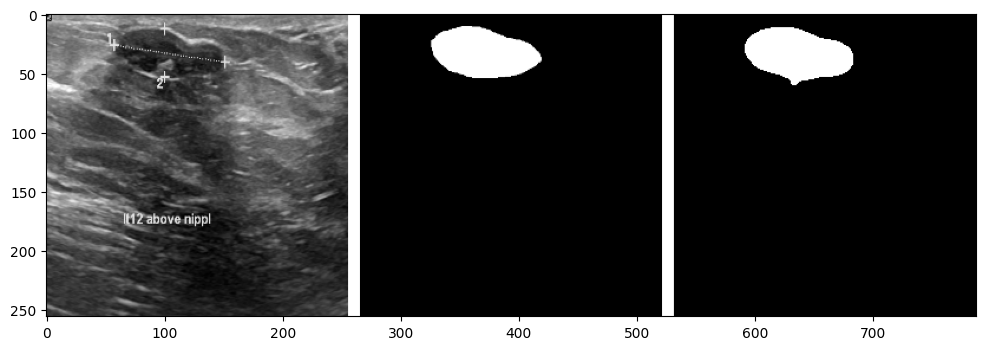

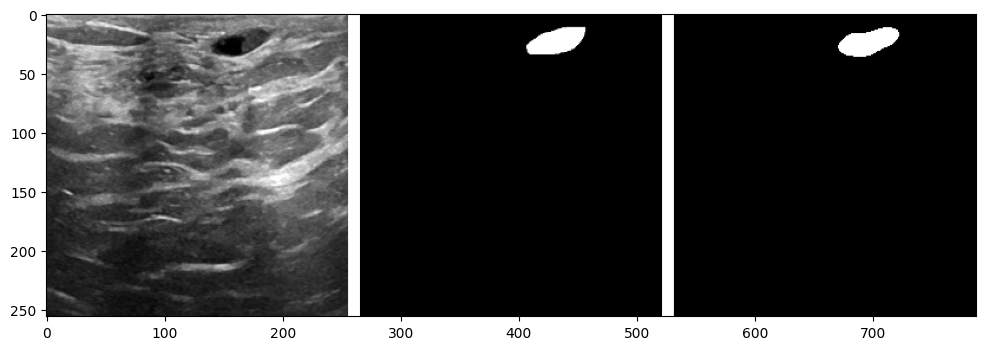

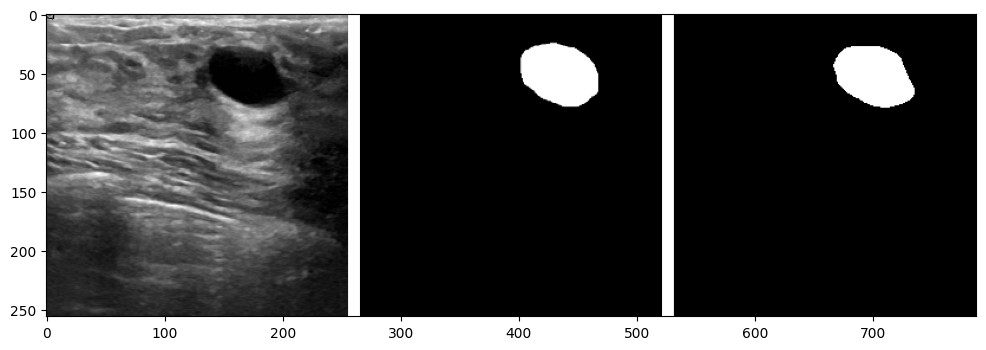

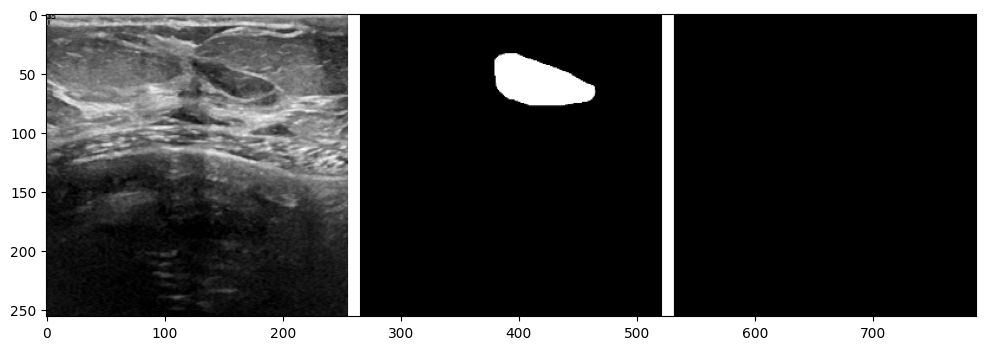

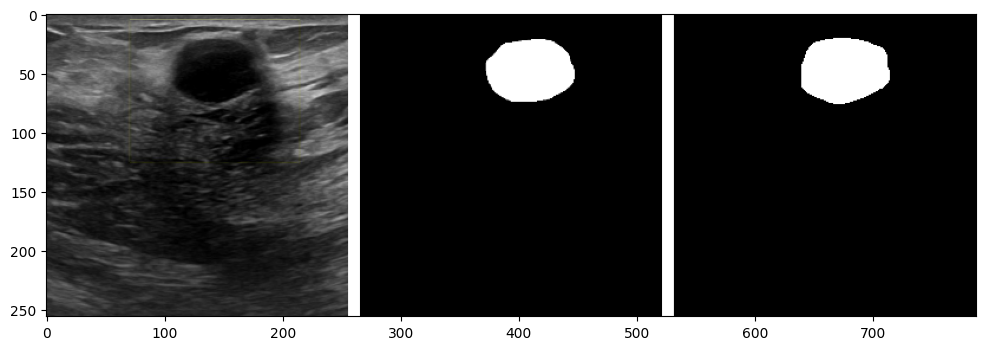

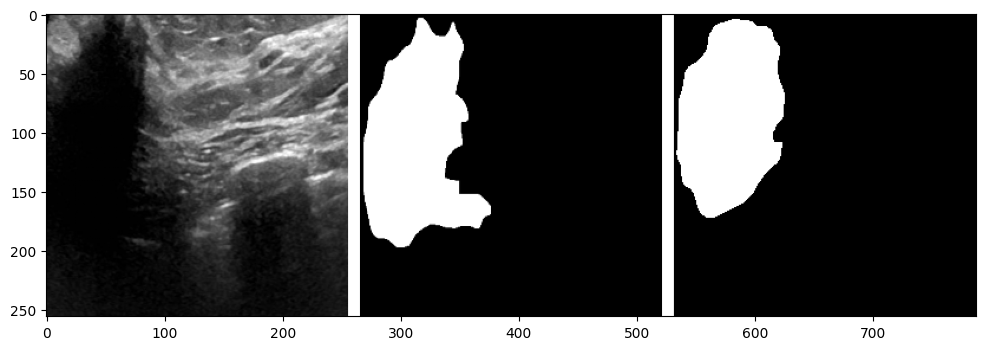

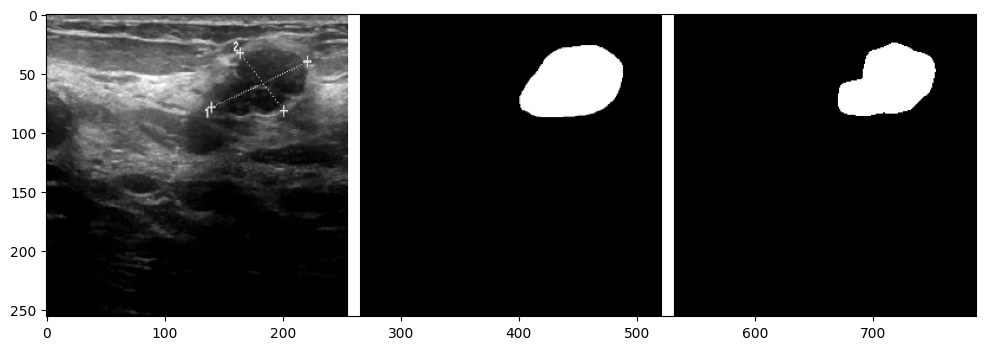

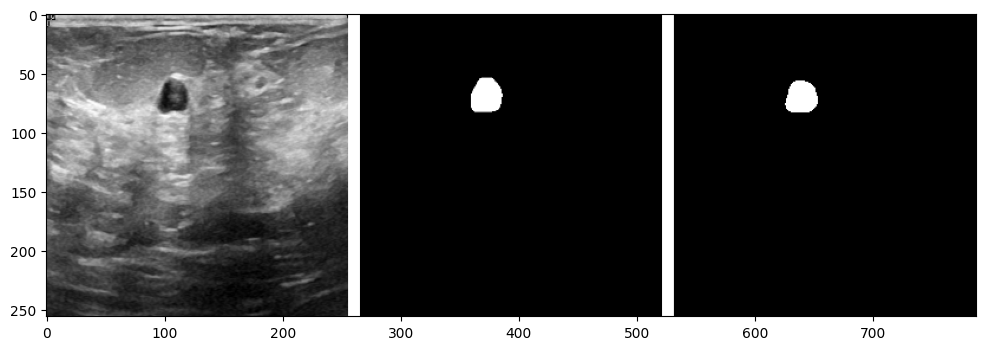

In [52]:
for i, (x, y) in enumerate(zip(test_x[:10], test_y[:10])):
    x = read_image(x)
    y = read_mask(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)

    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)